<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [67]:
#imports
import re

import pandas as pd
import seaborn as sns

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# get data
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [6]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [11]:
len(df['reviews.text'])

28332

In [22]:
# let's keep things simple with gensim's tokenizing
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [23]:
tokenize("Hi! I'll be your guy!")

['hi', 'll', 'guy']

In [24]:
# let's make a stream! exciting new python toy

def doc_stream(series):
    for i in range(len(series)):
        text = series[i]
        tokens = tokenize(text)
        yield tokens

In [34]:
amazon_stream = doc_stream(df['reviews.text'])

In [33]:
next(amazon_stream)

['duracell', 'price', 'happy']

In [35]:
# dictionary of all the words in the corpus

id2word = corpora.Dictionary(amazon_stream)

In [40]:
id2word.token2id['easy']

902

In [41]:
len(id2word.keys())

9622

In [42]:
# trim off most and least frequent
id2word.filter_extremes(no_below=5, no_above=0.95)

len(id2word.keys()) 
# oh wow that's almost forty percent of the words lost

3582

In [43]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(df['reviews.text'])]

In [46]:
# Latent Dirichlet Allocation -- trying fifteen topics first

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [47]:
lda.print_topics()

[(0,
  '0.055*"amazon" + 0.038*"tablet" + 0.022*"apps" + 0.022*"store" + 0.019*"google" + 0.018*"prime" + 0.018*"best" + 0.014*"play" + 0.013*"device" + 0.013*"app"'),
 (1,
  '0.052*"happy" + 0.041*"bought" + 0.035*"use" + 0.033*"gift" + 0.030*"kindle" + 0.026*"purchase" + 0.021*"purchased" + 0.016*"mother" + 0.015*"time" + 0.014*"expected"'),
 (2,
  '0.107*"tablet" + 0.035*"kids" + 0.029*"great" + 0.022*"games" + 0.017*"love" + 0.013*"apps" + 0.013*"bought" + 0.013*"free" + 0.013*"year" + 0.012*"memory"'),
 (3,
  '0.044*"ipad" + 0.030*"like" + 0.019*"light" + 0.017*"cover" + 0.016*"good" + 0.016*"amazon" + 0.013*"features" + 0.009*"small" + 0.009*"weight" + 0.009*"user"'),
 (4,
  '0.109*"batteries" + 0.031*"work" + 0.030*"long" + 0.021*"brand" + 0.020*"amazon" + 0.016*"battery" + 0.013*"brands" + 0.013*"buy" + 0.013*"good" + 0.012*"price"'),
 (5,
  '0.045*"kids" + 0.035*"love" + 0.023*"games" + 0.019*"play" + 0.019*"use" + 0.019*"parental" + 0.019*"apps" + 0.017*"easy" + 0.016*"perfec

In [52]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]

distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

df2 = pd.DataFrame.from_records(new_distro)
df2.columns = topics
df2['rating'] = df['reviews.rating']

df2.head()

,amazon tablet apps store google,happy bought use gift kindle,tablet kids great games love,ipad like light cover good,batteries work long brand amazon,kids love games play use,screen nice size tablet great,battery life tablet great books,apps ok bought slow thing,easy use tablet set love,kindle love reading books read,great price good product value,loves old year tablet bought,batteries working good time came,far good problems things satisfied,rating
0,0.000000,0.000000,0.000000,0.153365,0.589478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184429,0.000000,0.000000,0.000000,3
1,0.011111,0.011111,0.011111,0.591767,0.263788,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,4
2,0.016667,0.263943,0.016667,0.016667,0.293965,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.242091,0.016667,0.016667,0.016667,5
3,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,5
4,0.011111,0.011111,0.011111,0.011111,0.406723,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.448832,0.011111,0.011111,0.011111,5


In [55]:
df['reviews.text'][3]
# good match with topic "batteries work long brand amazon", as predicted

'Seem to work as well as name brand batteries at a much better price'

In [57]:
df2.groupby('rating').mean()
# "great price good product value" seems to
# meaningfully distinguish between 4/5 and lower scores
# results aren't super compelling

,amazon tablet apps store google,happy bought use gift kindle,tablet kids great games love,ipad like light cover good,batteries work long brand amazon,kids love games play use,screen nice size tablet great,battery life tablet great books,apps ok bought slow thing,easy use tablet set love,kindle love reading books read,great price good product value,loves old year tablet bought,batteries working good time came,far good problems things satisfied
rating,,,,,,,,,,,,,,,
1,0.042212,0.031665,0.034043,0.028188,0.402487,0.016012,0.023593,0.032971,0.081608,0.023982,0.018860,0.022973,0.017816,0.149523,0.030884
2,0.041177,0.030943,0.048550,0.040647,0.358927,0.037575,0.043548,0.057623,0.066009,0.026640,0.032746,0.031916,0.019057,0.091818,0.031528
3,0.086244,0.041390,0.072858,0.045758,0.228736,0.040494,0.048639,0.062528,0.065051,0.034467,0.044173,0.052127,0.047582,0.053573,0.031642
4,0.074948,0.047577,0.073889,0.038883,0.098012,0.062997,0.063001,0.050692,0.038971,0.054625,0.062918,0.113858,0.095445,0.033902,0.038273
5,0.039069,0.048300,0.053877,0.029041,0.156899,0.055902,0.045104,0.036147,0.024927,0.051257,0.069265,0.173189,0.097874,0.039000,0.032883


In [62]:


def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    # path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [64]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=10)

In [65]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [66]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.598526,2,0
1,-2.684678,8,0
2,-2.752847,14,0
3,-2.935450,20,0
4,-2.892571,26,0


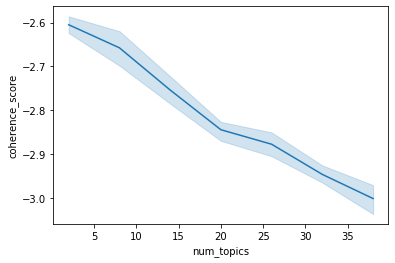

In [68]:
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)
# OOF

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling